## Boilerplate

In [4]:
# Typical imports
import numpy as np
from scipy.spatial import Delaunay
from scipy.interpolate import RegularGridInterpolator
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from pylab import *
import cv2
import math
import sys
print(sys.version)

3.11.4 (main, Jul  5 2023, 08:40:20) [Clang 14.0.6 ]


# For updating my helper functions:

In [5]:
# My own helper functions
import julians_little_helpers 
from julians_little_helpers import * 
# For reloading my helper functions when I make changes to them
import importlib
importlib.reload(julians_little_helpers)

<module 'julians_little_helpers' from '/Users/julian/Code/cs180/proj3/code/julians_little_helpers.py'>

# Part 1: Defining Correspondences
For this I chose to use a picture of myself (the photo I took for my student ID lol) and the given photo of George Clooney. 


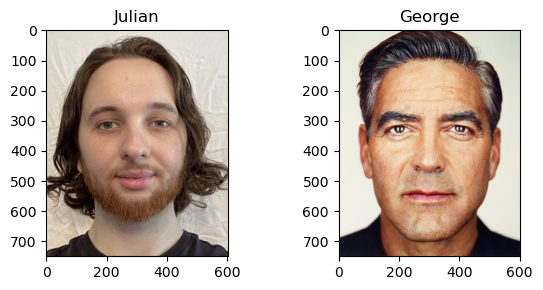

In [6]:
julian = read_im('../data/julian_portrait.jpg')
george = read_im('../data/george.jpg')
Display2Images(julian, george, 'Julian', 'George', 3)

#### Get the points I generated using this website: 
https://inst.eecs.berkeley.edu/~cs194-26/fa22/upload/files/proj3/cs194-26-aex/tool.html

(Thank you to whomever made this!)

In [7]:
# Import the correpsondence data
julian_pts, george_pts = GetPointsFromJSON('../data/julian_portrait_george.json')
julian_pts = np.array(julian_pts)
george_pts = np.array(george_pts)

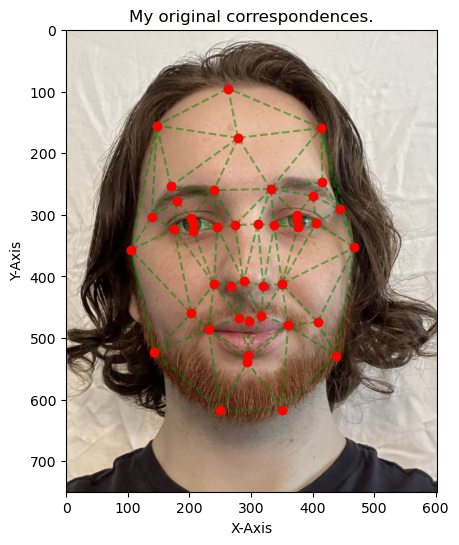

In [8]:
DisplayFaceTrisAndPts(julian, GetTriangulationObject(julian_pts), julian_pts, 'My original correspondences.')

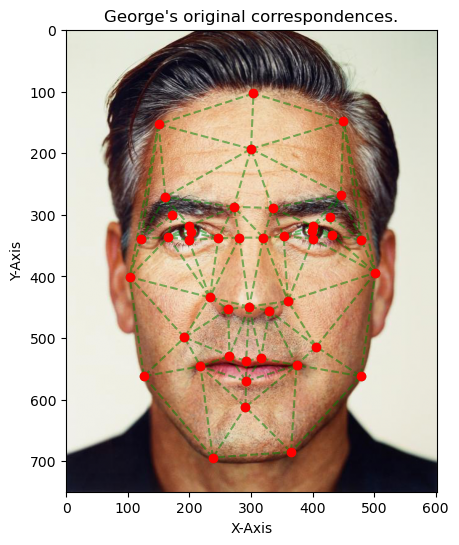

In [9]:
DisplayFaceTrisAndPts(george, GetTriangulationObject(george_pts), george_pts, 'George\'s original correspondences.')

#### Get the "mid-way" shape of our faces.
i.e. get the mean of each set of points

In [10]:
midway_pts = GetMidwayFace(julian_pts, george_pts)

#### Calculate the Delaunay triangulation of the mid-way shape face.

In [11]:
midway_triangulation = GetTriangulationObject(midway_pts)

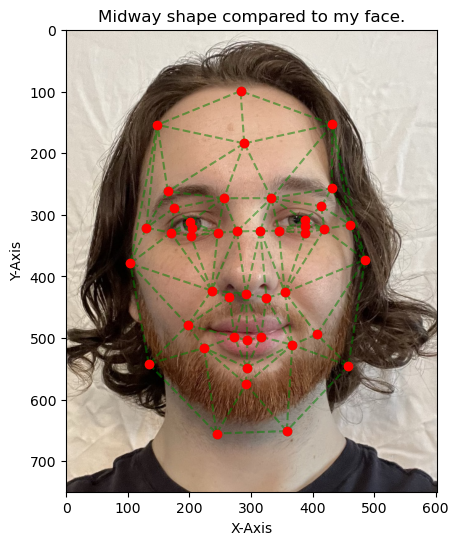

In [12]:
julian_tris = GetTriangulationObject(julian_pts)
DisplayFaceTrisAndPts(julian, midway_triangulation, midway_pts, 'Midway shape compared to my face.')

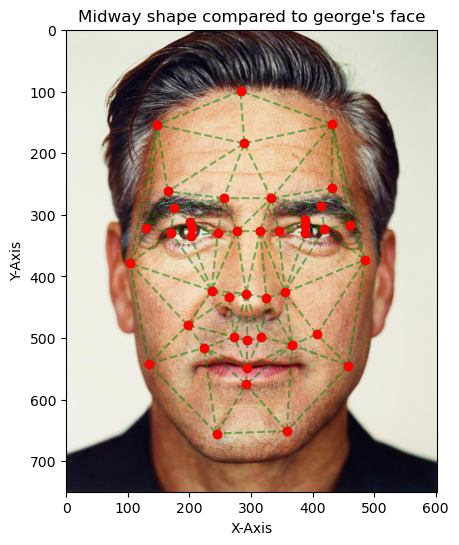

In [13]:
george_tris = GetTriangulationObject(george_pts)
DisplayFaceTrisAndPts(george, midway_triangulation, midway_pts, 'Midway shape compared to george\'s face')

# Compute the affine transformation for every triangle in on our faces.

In [14]:

tri1 = np.array([[1, 2], 
                 [3, 4], 
                 [5, 6]])
tri1 = ConvertPointsToHomogenous(tri1)

tri2 = np.array([[7, 8], 
                 [9, 10], 
                 [11, 12]])
tri2 = ConvertPointsToHomogenous(tri2)

T = ComputeAffine(tri1, tri2)

print(tri1)
print(tri2)
print(T)
print(T @ tri1[0])
print(T @ tri1[1])
print(T @ tri1[2])

[[1. 2. 1.]
 [3. 4. 1.]
 [5. 6. 1.]]
[[ 7.  8.  1.]
 [ 9. 10.  1.]
 [11. 12.  1.]]
[[-1.33333333  2.33333333  3.66666667]
 [-1.66666667  2.66666667  4.33333333]
 [ 0.          0.          1.        ]]
[7. 8. 1.]
[ 9. 10.  1.]
[11. 12.  1.]


It works!

# Warp all pixels to the midway face shape by transforming them by the transformation matrix that transforms the triangle they are inside of to the midway face shape.

#### Hint: Use a mask using skimage polygon and polygon2mask (https://scikit-image.org/docs/dev/api/skimage.draw.html#skimage.draw.polygon). You could then use the mask to select only the triangle's pixels, transform that new image, and add these up for all triangles.

### Testing how to get an array of all the raw triangles.

In [15]:
from scipy.spatial import Delaunay
julian_delaunay = Delaunay(julian_pts)
#print(julian_delaunay.points)
#print(julian_delaunay.simplices)
"""
print("")
for simplex in julian_delaunay.simplices:
    print(f"[{julian_delaunay.points[simplex[0]]}, {julian_delaunay.points[simplex[1]]}, {julian_delaunay.points[simplex[2]]}]")
print("]")
"""

'\nprint("")\nfor simplex in julian_delaunay.simplices:\n    print(f"[{julian_delaunay.points[simplex[0]]}, {julian_delaunay.points[simplex[1]]}, {julian_delaunay.points[simplex[2]]}]")\nprint("]")\n'

### How to transform each triangle's pixels? Loop through the triangles, and for each:
1. First, get a binary mask of all of the pixels in the triangle
2. Take the array slice of the image with the binary mask
3. Transform the masked image by that triangle's affine transformation to the corresponding triangle in the target image.
#### Then add up all of these images!


### Let's test it on one triangle first.

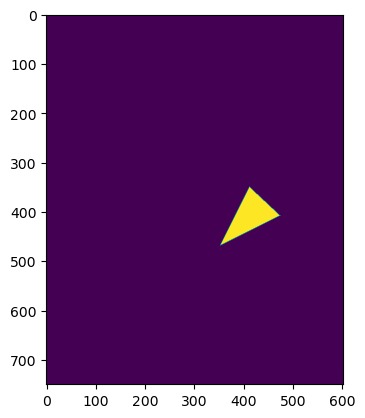

In [16]:
from skimage.draw import polygon2mask
from scipy.spatial import Delaunay
julian_delaunay = Delaunay(julian_pts)
# Single triangle test.
# Get the binary mask to select all pixels in the triangle.
tri_mask = polygon2mask(julian.shape[:2], julian_pts[julian_delaunay.simplices[0]]) # The first triangle in the triangulation
imshow(tri_mask)

### Let's try to make sure that the first triangle in George's triangulation is the same.

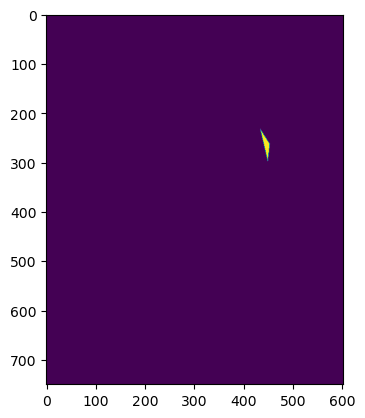

In [17]:
george_delaunay = Delaunay(george_pts)
tri_mask2 = polygon2mask(george.shape[:2], george_pts[george_delaunay.simplices[0]]) # The first triangle in the triangulation
imshow(tri_mask2)

### Ok. That's a bit of a problem. The simplices triangle matrix doesn't maintain the ordering of the points. 

Maybe there's a better solution, but here's what I'm thinking:
- the points in the julian_pts and george_pts arrays correspond based on index. 
- so, if I want to find the correpsonding triangle in both triangulations I should start with a point that I know the index of
- then, search for the triangles that have that point as an index (for both triangulations separately)
- the hard part is then matching 2 more points in any of those triangles to the other image's triangles...

### Ok. Actually its pretty easy because:
The simplices use the indices of the points in the julian_pts and george_pts arrays, which correspond.
So to find two corresponding triangles, we just need to get two triangles with the same simplices.

### Let's try this in a single instance.

In [18]:
# Get the first simplex in the triangulation
j_simplex1 = julian_delaunay.simplices[0]
print(j_simplex1)
# Let's find the corresponding triangle: search for the same simplex.
g_corr_simplex = None
matching_rows = [np.all(george_delaunay.simplices == j_simplex1, axis=1)]
print(matching_rows)

[36 35 23]
[array([False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])]


### I think I just realized that this is silly.
If every simplex exists in both triangles, then I can just iterate through the simplices from one of the triangulations and be fine...

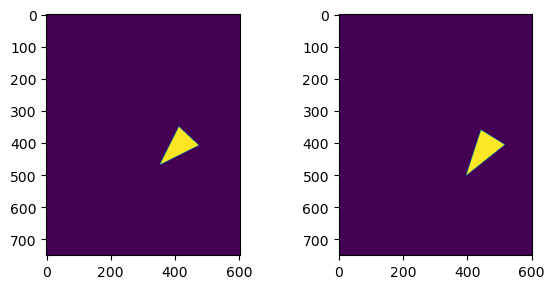

In [19]:
j_simplex1 = julian_delaunay.simplices[0]
j_mask1 = polygon2mask(julian.shape[:2], julian_pts[j_simplex1]) 
g_mask1 = polygon2mask(george.shape[:2], george_pts[j_simplex1])
Display2Images(j_mask1, g_mask1, '', '', 3)

# That's more like it!
#### Now, back to get the unmasked portion and transforming it!

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[408. 474.   1.]
 [350. 412.   1.]
 [468. 353.   1.]]
[[406. 514.   1.]
 [360. 440.   1.]
 [502. 394.   1.]]
[[  1.07263923  -0.26150121  92.31476998]
 [  0.1409946    1.06165021 -46.74799776]
 [  0.           0.           1.        ]]


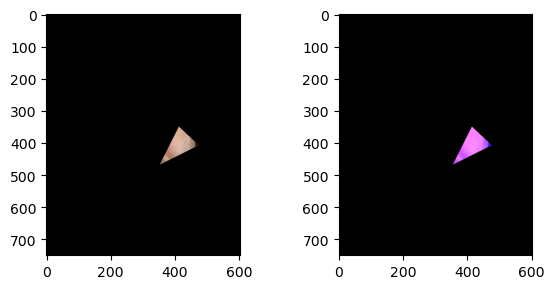

In [25]:
# Use the mask to perform binary array slicing.
j_tri = np.copy(julian)
j_tri [~j_mask1] = 0
# Compute transformation from one of my triangles to the corresponding triangle in george's face.
j_raw_tri = julian_pts[j_simplex1]
g_raw_tri = george_pts[j_simplex1]
# Convert triangle points to homogenous coordinates.
j_tri_pts = ConvertPointsToHomogenous(j_raw_tri)
print(j_tri_pts)
g_tri_pts = ConvertPointsToHomogenous(g_raw_tri)
print(g_tri_pts)
# Compute affine transfromation matrix from my triangle to george's triangle.
T = ComputeAffine(j_tri_pts, g_tri_pts)
print(T)
# Naively transform my triangle to george's triangle's shape.
j_tri_transformed = j_tri @ T
Display2Images(j_tri, j_tri_transformed, '', '', 3)

### Hm, clearly this was a naive implementation.
What I need to do is implement inverse warping. That means looping through all the pixels in the transformed shape, i.e. use the mask of george's triangle, and compute the coordinate in julian's image that correponds to the same point using the inverse of the transformation matrix. Because the resulting inverse coordinte is not necessarily an integer, I need to interpolate the value of the pixel at that coordinate. I can do this using bilinear interpolation.

In [42]:
# Testing the interpolation method.

x_dim = np.arange(0, julian.shape[1])
y_dim = np.arange(0, julian.shape[0])

r_interpolator = RegularGridInterpolator((y_dim, x_dim), julian[:,:,0], method='linear', bounds_error=False, fill_value=None)
g_interpolator = RegularGridInterpolator((y_dim, x_dim), julian[:,:,1], method='linear', bounds_error=False, fill_value=None)
b_interpolator = RegularGridInterpolator((y_dim, x_dim), julian[:,:,2], method='linear', bounds_error=False, fill_value=None)

def interpolate_rgb(yx_coord):
    r = r_interpolator(yx_coord)
    g = g_interpolator(yx_coord)
    b = b_interpolator(yx_coord)
    return np.array((r, g, b)).reshape(1,3)

def interpolate_rgb_h(homogenous):
    return interpolate_rgb((homogenous[0], homogenous[1]))

rgb_value = interpolate_rgb([[50.0, 100.0]])
print(rgb_value)
print(julian[50, 100])
print(interpolate_rgb_h([50.0, 100.0, 1.0]))

[[0.88627451 0.85882353 0.81960784]]
[0.88627451 0.85882353 0.81960784]
[[0.88627451 0.85882353 0.81960784]]


Transformation matrix: 
[[  1.07263923  -0.26150121  92.31476998]
 [  0.1409946    1.06165021 -46.74799776]
 [  0.           0.           1.        ]]
Inverse transformation matrix: 
[[  0.90304183   0.22243346 -72.96577947]
 [ -0.11993029   0.9123891   53.72370089]
 [  0.           0.           1.        ]]
[350. 412.   1.]
[350.90304183 411.88006971   1.        ]
[351.12547529 412.79245881   1.        ]
[351.80608365 411.76013942   1.        ]
[352.02851711 412.67252852   1.        ]
[352.25095057 413.58491762   1.        ]
[352.47338403 414.49730672   1.        ]
[352.70912548 411.64020913   1.        ]
[352.93155894 412.55259823   1.        ]
[353.1539924  413.46498733   1.        ]
[353.37642586 414.37737643   1.        ]
[353.59885932 415.28976553   1.        ]
[353.38973384 410.60788973   1.        ]
[353.6121673  411.52027883   1.        ]
[353.83460076 412.43266793   1.        ]
[354.05703422 413.34505703   1.        ]
[354.27946768 414.25744613   1.        ]
[354.50190114 415

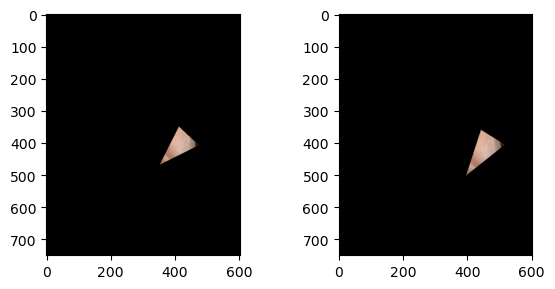

In [44]:
# Get the inverse of the transformation matrix.
T_inv = np.linalg.inv(T)
print(f"Transformation matrix: \n{T}")
print(f"Inverse transformation matrix: \n{T_inv}")

# Initialize transformed image to zeros.
j_tri_t = np.zeros_like(julian)

# For every pixel coordinate position that is True in the mask of the transformed image (g_mask1)
for y in range(g_mask1.shape[0]):
    for x in range(g_mask1.shape[1]):
        if g_mask1[y][x]:
            # Get inverse coord
            coord = np.array([y, x, 1]).T
            inverse_coord = T_inv @ coord
            print(inverse_coord)
            # Interpolate the value of the pixel at the inverse_coord.
            pixel_value = interpolate_rgb_h(inverse_coord)
            # set this coord to px value of inverse_coord
            j_tri_t[y][x] = pixel_value

Display2Images(j_tri, j_tri_t, '', '', 3)


# HOLD UP I THINK THAT ACTUALLY WORKED!

### Now, I just need to do this process for all of the triangles and add them up!

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


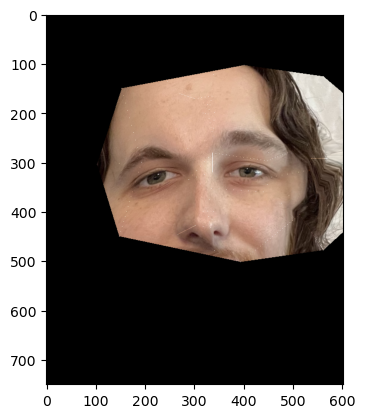

In [51]:
x_dim = np.arange(0, julian.shape[1])
y_dim = np.arange(0, julian.shape[0])

r_interpolator = RegularGridInterpolator((y_dim, x_dim), julian[:,:,0], method='linear', bounds_error=False, fill_value=None)
g_interpolator = RegularGridInterpolator((y_dim, x_dim), julian[:,:,1], method='linear', bounds_error=False, fill_value=None)
b_interpolator = RegularGridInterpolator((y_dim, x_dim), julian[:,:,2], method='linear', bounds_error=False, fill_value=None)

def interpolate_rgb(yx_coord):
    r = r_interpolator(yx_coord)
    g = g_interpolator(yx_coord)
    b = b_interpolator(yx_coord)
    return np.array((r, g, b)).reshape(1,3)

def interpolate_rgb_h(homogenous):
    return interpolate_rgb((homogenous[0], homogenous[1]))

j_tris_transformed_ims = []
# For all triangles in the triangulation:
for triangle_simplex in julian_delaunay.simplices:
    # Get the corresponding triangle shape from george's face.
    g_tri_mask_im = polygon2mask(george.shape[:2], george_pts[triangle_simplex])
    # Compute transformation from one of my triangles to the corresponding triangle in george's face.
    j_raw_tri = julian_pts[triangle_simplex]
    g_raw_tri = george_pts[triangle_simplex]
    # Convert triangle points to homogenous coordinates.
    j_tri_pts = ConvertPointsToHomogenous(j_raw_tri)
    g_tri_pts = ConvertPointsToHomogenous(g_raw_tri)
    # Compute affine transfromation matrix from my triangle to george's triangle.
    T = ComputeAffine(j_tri_pts, g_tri_pts)
    # Get the inverse of the transformation matrix.
    T_inv = np.linalg.inv(T)

    # Initialize transformed image to zeros.
    j_tri_t = np.zeros_like(julian)
    # For every pixel coordinate position that is True in the mask of the transformed image (g_mask1)
    for y in range(g_tri_mask_im.shape[0]):
        for x in range(g_tri_mask_im.shape[1]):
            if g_tri_mask_im[y][x]:
                # Get inverse coord
                coord = np.array([y, x, 1]).T
                inverse_coord = T_inv @ coord
                # Interpolate the value of the pixel at the inverse_coord.
                pixel_value = interpolate_rgb_h(inverse_coord)
                # set this coord to px value of inverse_coord
                j_tri_t[y][x] = pixel_value                 
    j_tris_transformed_ims.append(j_tri_t)

julian_transformed = np.zeros_like(julian)
for im in j_tris_transformed_ims:
    julian_transformed += im
imshow(julian_transformed) 

### Hm, something funky is going on...

In [50]:
print(len(j_tris_transformed_ims))
print(julian_delaunay.simplices)

77
[[36 35 23]
 [42 36 23]
 [24 41 40]
 [30 22 23]
 [30 29 22]
 [25  1 19]
 [20 25 19]
 [16 33 18]
 [24 10 14]
 [43 10 40]
 [10 24 40]
 [42 11 36]
 [13 11 14]
 [11 24 14]
 [11 35 36]
 [11 13 35]
 [11 42 41]
 [24 11 41]
 [33  0 18]
 [34 10 43]
 [10 34 33]
 [34 43 19]
 [ 1 34 19]
 [33 34  1]
 [17 13 18]
 [13 17 35]
 [17  2 35]
 [38 17 18]
 [ 2 17 38]
 [16 12 33]
 [12 10 33]
 [12 16 18]
 [13 12 18]
 [10 12 14]
 [37 38 18]
 [ 0 37 18]
 [ 6 33  1]
 [ 6  0 33]
 [ 2  8 35]
 [32  2 38]
 [29 32 22]
 [37 32 38]
 [15 13 14]
 [12 15 14]
 [15 12 13]
 [27 37  0]
 [27 32 37]
 [35  3 23]
 [ 8  3 35]
 [ 3 30 23]
 [31 32 29]
 [30 31 29]
 [ 3 31 30]
 [32  9  2]
 [31  9 32]
 [ 9 31  3]
 [ 7 27  0]
 [27 39 32]
 [22 39 21]
 [32 39 22]
 [39 20 21]
 [ 5  8  2]
 [ 9  5  2]
 [ 5  3  8]
 [ 5  9  3]
 [ 6  4  0]
 [ 4  7  0]
 [ 4  6  1]
 [ 7  4  1]
 [25 28  1]
 [28  7  1]
 [ 7 28 27]
 [26 25 20]
 [26 28 25]
 [28 26 27]
 [39 26 20]
 [26 39 27]]


# Compute the morph sequence by writing a function morph(...) 

#### which will have parameters for weighting the interpolation (either more of face 1 or more of face 2). Basically, run the warping procedure we've established up until now with weighted amount of warping between the images and weighted amounts of cross-dissolving. When those variables reach 1 (starting from 0) the morph sequence will be complete.
# TODO: implement this 

# Turn a sequence of computed interpolated images into a GIF which shows the face morph.

In [ ]:
# TODO: implement this